In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
datetime.now()

datetime.datetime(2020, 6, 20, 0, 18, 14, 683783)

In [3]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [4]:
url = 'https://ncov.dxy.cn/ncovh5/view/pneumonia'
driver.get(url)

### Extract date

In [5]:
content = driver.page_source
soup =BeautifulSoup(content, 'lxml')


In [6]:
data = soup.findAll(text=re.compile("截至.+"))
data

['try { window.getTimelineService1 = [{"id":55694,"pubDate":1592609072000,"pubDateStr":"42分钟前","title":"秘鲁累计确诊病例破24,7万例 国内航班或将在7月15日前复航","summary":"当地时间19日周五，秘鲁交通和通讯部长罗萨达称，目前卫生部计划在下周评估有关重启国内航班应执行的卫生安全方案。如相关程序进展顺利，秘鲁或将在7月15日前恢复国内航线的运营。同日，秘鲁总统再次强调，尽管该国新冠肺炎病毒传染率正在下降，各项经济活动正在有序重启，但民众仍应采取负责任的态度并保持谨慎，尤其是在商场及购物中心等场所重新开放后，前往时务必严格遵守各项规定。","infoSource":"央视新闻app","sourceUrl":"http://app.cctv.com/special/cportal/detail/arti/index.html?id=ArtiUpt57iOXmZLCeVMBEnaU200620&isfromapp=1","provinceId":""},{"id":55687,"pubDate":1592608126000,"pubDateStr":"58分钟前","title":"世卫称北京出现病毒与欧洲毒株密切相关","summary":"当地时间19日，世卫组织卫生紧急项目技术主管玛丽亚·范·科霍夫表示，北京出现的新冠病毒基因序列显示与欧洲毒株密切相关。世卫组织卫生紧急项目负责人称，这不代表疫情来自欧洲，此次的病毒很可能由北京以外输入，重要的是确定病毒传入时间及传播链。","infoSource":"央视新闻","sourceUrl":"https://m.weibo.cn/2656274875/4517788285040862","provinceId":""},{"id":55683,"pubDate":1592607933000,"pubDateStr":"1小时前","title":"巴西新冠确诊病例破百万","summary":"【巴西单日新增确诊5.4万例】据当地官方公报，当地时间19日，巴西新冠肺炎确诊病例单日新增54771例，总数已达1038568例，成为继美国之后第二个确诊数破百万的国家。当地卫生专家判断，巴西的疫情峰值仍未到来

In [7]:
for s in data:
    m = re.search("截至.*(202\d-\d+-\d+ \d+:\d+)", s)
    if m is not None:
        data_date_time = m.group(1)
data_date_time

'2020-06-20 08:14'

### Extract data (summary)

In [8]:
data = soup.findAll(text=re.compile('\"summary.+\"confirmedCount\":\d'))

data


['try { window.getStatisticsService = {"id":1,"createTime":1579537899000,"modifyTime":1592612055000,"infectSource":"该字段已替换为说明2","passWay":"该字段已替换为说明3","imgUrl":"https://img1.dxycdn.com/2020/0201/450/3394153392393266839-135.png","dailyPic":"https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png,https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png,https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png,https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png,https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png,https://img1.dxycdn.com/2020/0211/089/3395998939840182072-135.png","dailyPics":["https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png","https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png","https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png","https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png","https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png","https://i

In [9]:
m = re.search('\"confirmedCount\":(\d+)', data[0])
summary_confirmed_count = int(m.group(1))


m = re.search('\"curedCount\":(\d+)', data[0])
summary_cured_count = int(m.group(1))

m = re.search('\"deadCount\":(\d+)', data[0])
summary_dead_count = int(m.group(1))


In [10]:
# make a dataframe
df = pd.DataFrame({
    'datetime': data_date_time,
    'confirmed': summary_confirmed_count,
    'cured': summary_cured_count,
    'dead': summary_dead_count
}, index=[0])
df

,datetime,confirmed,cured,dead
0,2020-06-20 08:14,84943,79951,4645


### Save to file

In [11]:
from pathlib import Path
csv_file = '../data/china-summary-cases.csv'

if Path(csv_file).exists():
    # read out the old data - then merge with new data and remove duplicates based on datetime
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['datetime'], inplace=True)

In [12]:
df.sort_values(by=['datetime'], inplace=True)

df.to_csv(csv_file, index=False)


### Plot graph

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = '../images/china-summary-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")

df.set_index('datetime_idx', inplace=True)
df.drop(['datetime'], axis=1, inplace=True)


In [14]:
df

,confirmed,cured,dead
datetime_idx,,,
2020-02-02 10:22:00,14483,379,304
2020-02-02 10:28:00,14483,380,304
2020-02-02 11:19:00,14489,385,304
2020-02-02 11:54:00,14489,397,304
2020-02-02 15:01:00,14490,430,304
...,...,...,...
2020-06-19 18:56:00,84943,79951,4645
2020-06-19 21:13:00,84943,79951,4645
2020-06-19 22:23:00,84943,79951,4645


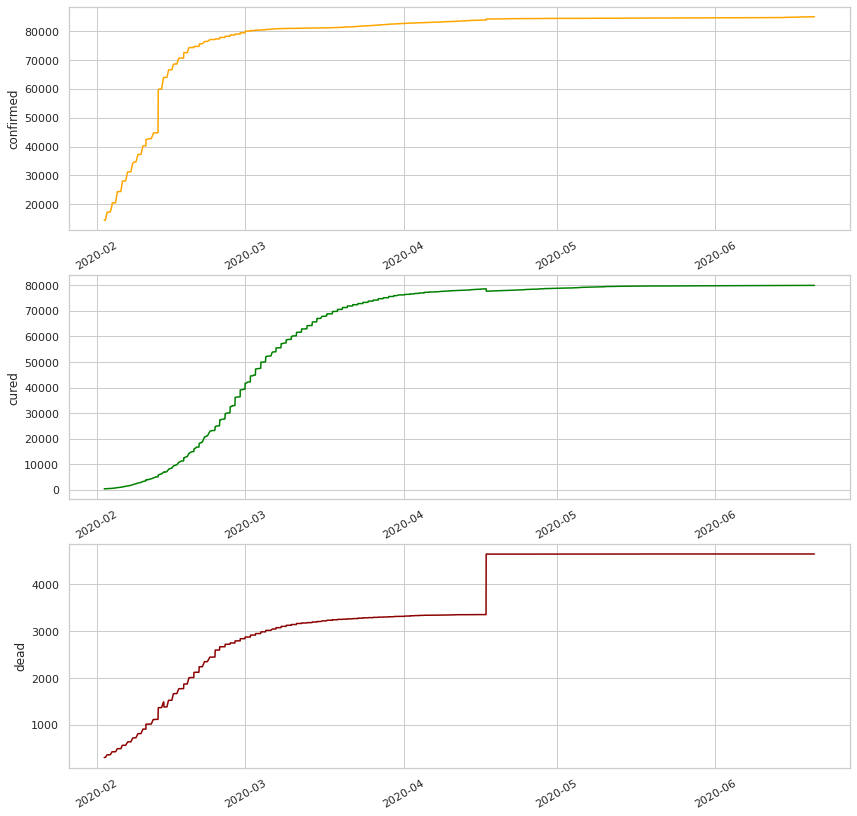

In [15]:
if df.shape[0]>1:
    # line chart when having at least a few points
    sns.set(rc={'figure.figsize':(14,14)})
    sns.set(style="whitegrid")

    fig, axs = plt.subplots(nrows=3)

    sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
    sns.lineplot(x=df.index, y = 'cured', data=df, ax= axs[1], estimator=None, color='green')
    sns.lineplot(x=df.index, y = 'dead', data=df, ax= axs[2], estimator=None, color='darkred')

    for ax in axs:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=30)
else:

    ax = df.plot(kind='bar', stacked=True, figsize=(9,6))
    fig = ax.get_figure()
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(0) 


In [16]:
fig.savefig(png_file)